In [1]:
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
pd.set_option('display.max_columns', 50)

In [2]:
# Headers for querying NBA JSON data api
header_data  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

In [3]:
# code for getting starting quarter lineups from here: https://github.com/rd11490/NBA-Play-By-Play-Example
def play_by_play_url(game_id):
    """Pull play-by-play data. This is used in determining who was on the court and how many net points they accounted for.
    Basketball isn't as simple as seeing who has high plus-minus stats, since 1 bad player can be surrounded by 4 great players
    and still have a high net point total. I account for that with regression later, and I need full play by play data
    in order to process and compile that controlled regression data."""
    return "https://stats.nba.com/stats/playbyplayv2/?gameId={0}&startPeriod=0&endPeriod=14".format(game_id)

def advanced_boxscore_url(game_id, start, end):
    """Pull advanced box score data"""
    return "https://stats.nba.com/stats/boxscoreadvancedv2/?gameId={0}&startPeriod=0&endPeriod=14&startRange={1}&endRange={2}&rangeType=2".format(game_id, start, end)

def games_url(season,season_type):
    """Pull list of games data"""
    return 'https://stats.nba.com/stats/leaguegamelog?Counter=1000&DateFrom=&DateTo=&Direction=DESC&LeagueID=00&PlayerOrTeam=T&Season={}&SeasonType={}&Sorter=DATE'.format(season,season_type)

def players_url(season,season_type,historical=1):
    """Pull list of players data"""
    return 'https://stats.nba.com/stats/playerindex?LeagueID=00&season={}&SeasonType={}&Historical={}'.format(season,season_type,historical)

def player_minutes_url(season,season_type):
    """Pull minutes by player data"""
    return 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='.format(season,season_type)

def players_box_url(season,season_type,per_mode,measure_type):
    """Pull player box score data"""
    return "https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=&Season={}&SeasonType={}&PerMode={}&MeasureType={}".format(season,season_type,per_mode,measure_type)

def players_hustle_url(season,season_type,per_mode):
    """Pull player hustle stats data"""
    return "https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&TeamID=0&VsConference=&VsDivision=&Weight=&PerMode={}&Season={}&SeasonType={}".format(per_mode,season,season_type)

def players_drives_url(season,season_type,per_mode):
    """Pull player driving stats data"""
    return "https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode={}&PlayerExperience=&PlayerOrTeam=Player&PlayerPosition=&PtMeasureType=Drives&Season={}&SeasonSegment=&SeasonType={}&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def players_distance_url(season,season_type,per_mode):
    """Pull player distance traveled tracking data"""
    return "https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode={}&PlayerExperience=&PlayerOrTeam=Player&PlayerPosition=&PtMeasureType=SpeedDistance&Season={}&SeasonSegment=&SeasonType={}&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def teams_box_url(season,season_type,per_mode,measure_type):
    """Pull team box score data data"""
    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType={}&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode={}&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=".format(measure_type,per_mode,season,season_type)

def teams_hustle_url(season,season_type,per_mode):
    """Pull team hustle stats data"""
    return "https://stats.nba.com/stats/leaguehustlestatsteam?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode={}&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def teams_drives_url(season,season_type,per_mode):
    """Pull team driving stats data"""
    return "https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode={}&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=Drives&Season={}&SeasonSegment=&SeasonType={}&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def teams_distance_url(season,season_type,per_mode):
    """Pull team distance traveled tracking data"""
    return "https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode={}&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=SpeedDistance&Season={}&SeasonSegment=&SeasonType={}&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def teams_opponent_box_url(season,season_type,per_mode):
    """Pull team opponent box score data"""
    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode={}&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=".format(per_mode,season,season_type)

def players_opponent_box_url(season,season_type,per_mode):
    """Pull player opponent box score data"""
    return "https://stats.nba.com/stats/leagueplayerondetails?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode={}&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={}&SeasonSegment=&SeasonType={}&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=".format(per_mode,season,season_type)

def extract_data(url):
    "Get the table data from NBA stats api"
    resp = requests.get(url, headers=header_data).json()
    results = resp['resultSets'][0]
    headers = results['headers']
    rows = results['rowSet']
    frame = pd.DataFrame(rows)
    frame.columns = headers
    return frame

def calculate_time_at_period(period):
    "Get the time at period for finding out which players were on the court at the start of the quarter"
    if period > 5:
        return (720 * 4 + (period - 5) * (5 * 60)) * 10
    else:
        return (720 * (period - 1)) * 10
    
def split_subs(df, tag):
    subs = df[[tag, 'PERIOD', 'EVENTNUM']]
    subs['SUB'] = tag
    subs.columns = ['PLAYER_ID', 'PERIOD', 'EVENTNUM', 'SUB']
    return subs

def get_player_box_and_hustle(season,season_type,per_mode,min_minutes):
    """Get traditional, advanced, hustle, and team opponent stats per player.
    Normalize stats per 100 possessions.
    Attribute 1/5th of opponent stats to the player."""
    # Traditional stats and cleaning for makes and misses of each shot type
    box = extract_data(players_box_url(season,season_type,per_mode,'Base'))
    box['FG2MA'] = box['FGM']-box['FG3M']
    box['FG2MI'] = box['FGA']-box['FG3A']-box['FG2MA']
    box['FG3MA'] = box['FG3M']
    box['FG3MI'] = box['FG3A']-box['FG3M']
    box['FTMA'] = box['FTM']
    box['FTMI'] = box['FTA']-box['FTM']
    box = box[['PLAYER_ID','PLAYER_NAME','GP','W','L','MIN','FG2MA','FG2MI','FG3MA','FG3MI','FTMA','FTMI','OREB','DREB','AST','TOV','STL','BLK','BLKA','PF','PFD','PLUS_MINUS']]
    # Advanced stats
    advanced = extract_data(players_box_url(season,season_type,per_mode,'Advanced'))
    advanced = advanced[['PLAYER_ID','POSS']]
    # Hustle stats
    hustle = extract_data(players_hustle_url(season,season_type,per_mode))
    hustle = hustle[['PLAYER_ID','CONTESTED_SHOTS_2PT','CONTESTED_SHOTS_3PT','DEFLECTIONS','CHARGES_DRAWN','SCREEN_AST_PTS','OFF_LOOSE_BALLS_RECOVERED','DEF_LOOSE_BALLS_RECOVERED','OFF_BOXOUTS','DEF_BOXOUTS']]
    # Drives
    drives = extract_data(players_drives_url(season,season_type,per_mode))
    drives = drives[['PLAYER_ID','DRIVES','DRIVE_PASSES']]
    drives.rename({'PASS':'DRIVES_PASS'}, axis=1, inplace=True)
    # Distance traveled
    distance = extract_data(players_distance_url(season,season_type,per_mode))
    distance = distance[['PLAYER_ID','MIN','DIST_MILES_OFF','DIST_MILES_DEF']]
    distance['DIST_MIN']=distance['MIN']
    distance.drop('MIN', axis=1, inplace=True)
    # Get opponent data and divide by 5 since 1/5th of it can be attributed to any player on the court at a time (approximately)
    opponent = extract_data(players_opponent_box_url(season,season_type,per_mode))
    opponent['OPP_FG2MA'] = opponent['OPP_FGM']-opponent['OPP_FG3M']
    opponent['OPP_FG2MI'] = opponent['OPP_FGA']-opponent['OPP_FG3A']-opponent['OPP_FG2MA']
    opponent['OPP_FG3MA'] = opponent['OPP_FG3M']
    opponent['OPP_FG3MI'] = opponent['OPP_FG3A']-opponent['OPP_FG3M']
    opponent['OPP_FTMA'] = opponent['OPP_FTM']
    opponent['OPP_FTMI'] = opponent['OPP_FTA']-opponent['OPP_FTM']
    opponent = opponent[['VS_PLAYER_ID','OPP_FG2MA','OPP_FG2MI','OPP_FG3MA','OPP_FG3MI','OPP_FTMA','OPP_FTMI','OPP_OREB','OPP_DREB','OPP_AST','OPP_TOV','OPP_STL','OPP_BLK','OPP_BLKA','OPP_PF','OPP_PFD']]
    # Players can have multiple rows if in multiple teams. Group by and sum all their stats
    opponent = opponent.groupby('VS_PLAYER_ID').agg('sum').reset_index()
    # Divide by 5 since each player's opponent work can be approximated as 1/5th theirs
    opponent.iloc[:,1:] = opponent.iloc[:,1:]/5
    opponent.rename(columns={'VS_PLAYER_ID':'PLAYER_ID'}, inplace=True)
    # Join the dataframes
    final = box.merge(advanced, how='inner', on='PLAYER_ID').merge(hustle, how='inner', on='PLAYER_ID')\
            .merge(distance, how='left', on='PLAYER_ID')\
            .merge(opponent, how='left', on='PLAYER_ID')\
            .merge(drives, how='left', on='PLAYER_ID')
    # Since distance tracking isn't in every game, adjust by total minutes over distance tracking minutes 
    for dist_col in ['DIST_MILES_OFF','DIST_MILES_DEF']:
        final[dist_col]=final[dist_col]*final['MIN']/final['DIST_MIN']
    # Drop the unneeded distance min column and fill values with mean
    final.drop('DIST_MIN', axis=1, inplace=True)
    final.iloc[:,6:].fillna(final.iloc[:,6:].mean(), inplace=True)
    # Calculate per-100-poss numbers for relevant things
    final.iloc[:,6:]=100*final.iloc[:,6:].div(final['POSS'], axis=0)
    return final[final['MIN']>=min_minutes]

def get_team_box_and_hustle(season,season_type,per_mode,min_minutes):
    """Get traditional, advanced, hustle, and team opponent stats per team.
    Normalize stats per 100 possessions."""
    # Traditional stats and cleaning for makes and misses of each shot type
    box = extract_data(teams_box_url(season,season_type,per_mode,'Base'))
    box['FG2MA'] = box['FGM']-box['FG3M']
    box['FG2MI'] = box['FGA']-box['FG3A']-box['FG2MA']
    box['FG3MA'] = box['FG3M']
    box['FG3MI'] = box['FG3A']-box['FG3M']
    box['FTMA'] = box['FTM']
    box['FTMI'] = box['FTA']-box['FTM']
    box = box[['TEAM_ID','TEAM_NAME','GP','W','L','MIN','FG2MA','FG2MI','FG3MA','FG3MI','FTMA','FTMI','OREB','DREB','AST','TOV','STL','BLK','BLKA','PF','PFD','PLUS_MINUS']]
    # Advanced stats
    advanced = extract_data(teams_box_url(season,season_type,per_mode,'Advanced'))
    advanced = advanced[['TEAM_ID','POSS']]
    # Hustle stats
    hustle = extract_data(teams_hustle_url(season,season_type,per_mode))
    hustle = hustle[['TEAM_ID','CONTESTED_SHOTS_2PT','CONTESTED_SHOTS_3PT','DEFLECTIONS','CHARGES_DRAWN','SCREEN_AST_PTS','OFF_LOOSE_BALLS_RECOVERED','DEF_LOOSE_BALLS_RECOVERED','OFF_BOXOUTS','DEF_BOXOUTS']]
    # Drives
    drives = extract_data(teams_drives_url(season,season_type,per_mode))
    drives = drives[['TEAM_ID','DRIVES','DRIVE_PASSES']]
    # Distance traveled
    distance = extract_data(teams_distance_url(season,season_type,per_mode))
    distance = distance[['TEAM_ID','MIN','DIST_MILES_OFF','DIST_MILES_DEF']]
    distance['DIST_MIN']=distance['MIN']
    distance.drop('MIN', axis=1, inplace=True)
    # Get opponnent data
    opponent = extract_data(teams_opponent_box_url(season,season_type,per_mode))
    opponent['OPP_FG2MA'] = opponent['OPP_FGM']-opponent['OPP_FG3M']
    opponent['OPP_FG2MI'] = opponent['OPP_FGA']-opponent['OPP_FG3A']-opponent['OPP_FG2MA']
    opponent['OPP_FG3MA'] = opponent['OPP_FG3M']
    opponent['OPP_FG3MI'] = opponent['OPP_FG3A']-opponent['OPP_FG3M']
    opponent['OPP_FTMA'] = opponent['OPP_FTM']
    opponent['OPP_FTMI'] = opponent['OPP_FTA']-opponent['OPP_FTM']
    opponent = opponent[['TEAM_ID','OPP_FG2MA','OPP_FG2MI','OPP_FG3MA','OPP_FG3MI','OPP_FTMA','OPP_FTMI','OPP_OREB','OPP_DREB','OPP_AST','OPP_TOV','OPP_STL','OPP_BLK','OPP_BLKA','OPP_PF','OPP_PFD']]
    # Join the dataframes
    final = box.merge(advanced, how='inner', on='TEAM_ID').merge(hustle, how='inner', on='TEAM_ID')\
            .merge(distance, how='left', on='TEAM_ID')\
            .merge(opponent, how='left', on='TEAM_ID')\
            .merge(drives, how='left', on='TEAM_ID')
    # Since distance tracking isn't in every game, adjust by total minutes over distance tracking minutes 
    for dist_col in ['DIST_MILES_OFF','DIST_MILES_DEF']:
        final[dist_col]=final[dist_col]*final['MIN']/final['DIST_MIN']
    # Drop the unneeded distance min column and fill values with mean
    final.drop('DIST_MIN', axis=1, inplace=True)
    final.iloc[:,6:].fillna(final.iloc[:,6:].mean(), inplace=True)
    # Calculate per-100-poss numbers for relevant things
    final.iloc[:,6:]=100*final.iloc[:,6:].div(final['POSS'], axis=0)
    return final[final['MIN']>=min_minutes]

def get_all_games(season,season_type):
    "Pull all games in the season"
    games = extract_data(games_url(season,season_type))
    games = games[games['MATCHUP'].str.contains('vs.')][['GAME_ID','MATCHUP']]
    games['HOME']=games['MATCHUP'].str.split(' vs. ').str.get(0)
    games['AWAY']=games['MATCHUP'].str.split(' vs. ').str.get(1)
    return games

def get_player_general(season,season_type):
    "Get general info for the player, especially their position"
    player_general = extract_data(players_url(season,season_type))
    player_general = player_general[['PLAYER_FIRST_NAME','PLAYER_LAST_NAME','TEAM_ABBREVIATION',
                                     'PERSON_ID',
                                     'POSITION','HEIGHT','WEIGHT','DRAFT_YEAR','FROM_YEAR','TO_YEAR']]
    player_general.rename({'PERSON_ID':'PLAYER_ID'},axis=1,inplace=True)
    return player_general

def get_player_minutes(season,season_type):
    """Get how many minutes the player played in a season.
    Originally used this to throw out players under a certain minutes threshold, but decided not to."""
    player_minutes = extract_data(player_minutes_url(season,season_type))
    return player_minutes[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP','MIN']]


def get_game_data(game_id,games):
    """Get play-by-play data with each player on the court, adjusting for substitions in and out."""
    frame = extract_data(play_by_play_url(game_id)).fillna('')
    # Get the substitutions
    substitutionsOnly = frame[frame["EVENTMSGTYPE"] == 8][['PERIOD', 'EVENTNUM', 'PLAYER1_ID', 'PLAYER2_ID']]
    substitutionsOnly.columns = ['PERIOD', 'EVENTNUM', 'OUT', 'IN']

    subs_in = split_subs(substitutionsOnly, 'IN')
    subs_out = split_subs(substitutionsOnly, 'OUT')

    full_subs = pd.concat([subs_out, subs_in], axis=0).reset_index()[['PLAYER_ID', 'PERIOD', 'EVENTNUM', 'SUB']]
    first_event_of_period = full_subs.loc[full_subs.groupby(by=['PERIOD', 'PLAYER_ID'])['EVENTNUM'].idxmin()]
    players_subbed_in_at_each_period = first_event_of_period[first_event_of_period['SUB'] == 'IN'][['PLAYER_ID', 'PERIOD', 'SUB']]

    periods = frame['PERIOD'].drop_duplicates().values.tolist()

    # Example of processing starting players in the period from here https://github.com/rd11490/NBA-Play-By-Play-Example 

    frames = []
    for period in periods:

        low = calculate_time_at_period(period) + 5
        high = calculate_time_at_period(period + 1) - 5
        boxscore = advanced_boxscore_url(game_id, low, high)
        boxscore_players = extract_data(boxscore)[['PLAYER_NAME', 'PLAYER_ID', 'TEAM_ABBREVIATION']]
        boxscore_players['PERIOD'] = period

        players_subbed_in_at_period = players_subbed_in_at_each_period[players_subbed_in_at_each_period['PERIOD'] == period]

        joined_players = pd.merge(boxscore_players, players_subbed_in_at_period, on=['PLAYER_ID', 'PERIOD'], how='left')
        joined_players = joined_players[pd.isnull(joined_players['SUB'])][['PLAYER_NAME', 'PLAYER_ID', 'TEAM_ABBREVIATION', 'PERIOD']]
        frames.append(joined_players)

    out = pd.concat(frames)
    out = out.groupby(['TEAM_ABBREVIATION','PERIOD'])['PLAYER_ID'].apply(lambda x: ','.join(map(str, x))).reset_index()
    # # Originally planning to add commas for better replace later, but decided to handle in dataframe later
    # out['PLAYER_IDS'] = ','+out['PLAYER_ID']+','
    
    # Get home and away game data
    frame['HOME']=games[games['GAME_ID']==game_id]['HOME'].values[0]
    frame['AWAY']=games[games['GAME_ID']==game_id]['AWAY'].values[0]
    frame = frame.merge(out,how='left',left_on=['HOME','PERIOD'],right_on=['TEAM_ABBREVIATION','PERIOD']).drop('TEAM_ABBREVIATION',axis=1)
    frame.rename({'PLAYER_ID':'HOME_PLAYER_IDS'},axis=1,inplace=2)
    frame = frame.merge(out,how='left',left_on=['AWAY','PERIOD'],right_on=['TEAM_ABBREVIATION','PERIOD']).drop('TEAM_ABBREVIATION',axis=1)
    frame.rename({'PLAYER_ID':'AWAY_PLAYER_IDS'},axis=1,inplace=2)
    return frame

In [4]:
season = '2021-22'
season_type = 'Regular+Season'
per_mode = 'Totals'
min_minutes = 500
games = get_all_games(season,season_type)
# games

In [5]:
players = get_player_general(season,season_type)
# players

In [6]:
players_box = get_player_box_and_hustle(season,season_type,per_mode,min_minutes)
# players_box

In [7]:
def grid_search_regress(dataframe, model, parameters, y_value, drop_columns=[], scoring='r2', cv=5):
    "Run gridsearch on a regression"
    X = dataframe.drop(drop_columns+[y_value], axis=1, errors='ignore')
    y = dataframe[y_value]
    grid_search = GridSearchCV(model, parameters, scoring=scoring, cv=cv)
    grid_search.fit(X, y)
    return grid_search

def regress_after_grid_search(dataframe, model, y_value, drop_columns=[]):
    "Regress, use this on the model after grid search"
    X = dataframe.drop(drop_columns+[y_value], axis=1, errors='ignore')
    y = dataframe[y_value]
    model.fit(X, y)
    return model

def get_player_box_from_regress(dataframe, model, y_value, drop_columns=[]):
    "Get predicted box from regression model"
    return model.predict(dataframe.drop(drop_columns+[y_value], axis=1, errors='ignore'))

y_value = 'PLUS_MINUS'
model = Ridge()
drop_columns = ['PLAYER_ID', 'PLAYER_NAME', 'GP', 'W', 'L', 'MIN', 'POSS', 'TEAM_ID', 'TEAM_NAME', 'POSITION']

Best parameters: {'alpha': 0.25}. Best Score: 0.8732088488660985


,coef,stat
35,4.982488,OPP_TOV
27,4.209188,OPP_FG2MI
29,4.196620,OPP_FG3MI
39,1.701288,OPP_PF
2,1.692765,FG3MA
31,0.922557,OPP_FTMI
0,0.457173,FG2MA
21,0.444320,DEF_LOOSE_BALLS_RECOVERED
34,0.424690,OPP_AST
6,0.383825,OREB


,PLAYER_ID,PLAYER_NAME,GP,W,L,MIN,FG2MA,FG2MI,FG3MA,FG3MI,FTMA,FTMI,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS,POSS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,...,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,DIST_MILES_OFF,DIST_MILES_DEF,OPP_FG2MA,OPP_FG2MI,OPP_FG3MA,OPP_FG3MI,OPP_FTMA,OPP_FTMI,OPP_OREB,OPP_DREB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,DRIVES,DRIVE_PASSES,PRED+/-
20,2738,Andre Iguodala,31,20,11,602.831667,2.314445,1.436552,1.356744,4.549082,1.197127,0.399042,1.675978,6.304868,9.098164,2.234637,2.154828,1.755786,0.159617,2.713488,2.873105,9.098164,100.0,4.549082,2.952913,...,2.793296,0.638468,0.558659,0.079808,1.516361,1.807260,1.617456,4.708699,5.011971,2.282522,5.107741,3.048683,1.324820,1.995211,6.783719,4.293695,3.383879,1.356744,0.814046,1.117318,3.703113,3.926576,1.835595,1.197127,13.285495
279,1628369,Jayson Tatum,76,49,27,2730.971667,8.569380,7.798494,4.123342,7.547508,7.171029,1.237003,1.523844,9.394048,5.987809,3.890283,1.344568,0.878451,1.487989,3.119398,6.131230,11.957691,100.0,3.872356,3.531732,...,1.577626,0.699175,0.501972,0.017928,0.501972,1.797554,1.508271,5.259950,5.371101,2.352098,4.689853,3.133740,0.842596,2.047329,6.518465,4.324131,2.828971,1.470061,0.849767,1.204733,3.922553,3.671567,15.292219,4.912155,11.608708
87,101108,Chris Paul,65,53,12,2138.958333,6.717421,5.306762,1.410658,3.045231,3.784147,0.738916,0.492611,5.844156,15.718764,3.425884,2.709360,0.447828,0.268697,3.000448,4.612629,10.300045,100.0,1.253918,2.507837,...,1.410658,0.515002,0.873265,0.000000,0.671742,1.706447,1.392461,5.709807,5.338110,2.180923,4.567846,3.090013,0.886700,2.180923,6.842812,4.608150,2.892969,1.285266,0.658307,0.806090,3.878191,3.663233,17.039857,8.531124,11.218444
526,201939,Stephen Curry,64,45,19,2211.085000,5.377501,4.818240,6.130351,10.002151,5.915251,0.494730,0.731340,6.474511,8.690041,4.431060,1.828350,0.494730,0.838890,2.796300,4.861260,10.948591,100.0,2.495160,3.656700,...,3.377070,0.774360,0.688320,0.064530,0.494730,1.981147,1.520816,5.226931,5.011831,2.280060,4.770918,3.342654,1.023876,2.039148,6.435793,4.405248,3.015702,1.634760,0.752850,1.002366,3.506130,4.155732,13.207141,5.786191,10.957429
308,1630631,Jose Alvarado,54,25,29,833.908333,5.637813,4.840547,1.822323,4.441913,2.050114,0.968109,1.423690,4.271071,8.656036,2.277904,4.043280,0.398633,1.082005,4.157175,2.961276,8.143508,100.0,2.505695,4.441913,...,1.822323,0.797267,0.626424,0.000000,0.854214,2.013814,1.858018,5.045558,4.179954,2.289294,4.419134,3.826879,0.888383,1.628702,6.138952,4.783599,3.462415,1.309795,0.979499,0.888383,4.191344,4.100228,15.945330,7.517084,10.421030
158,1628415,Dillon Brooks,32,22,10,885.026667,9.668803,10.470085,2.457265,5.502137,4.807692,0.854701,1.549145,3.899573,4.700855,2.670940,1.923077,0.427350,1.442308,5.608974,5.822650,11.004274,100.0,4.540598,4.754274,...,0.961538,0.801282,0.694444,0.106838,0.747863,1.735140,1.729649,5.416667,5.106838,2.264957,4.134615,3.547009,1.014957,1.826923,6.410256,4.722222,3.290598,1.239316,1.239316,1.185897,4.230769,3.878205,14.636752,2.617521,10.273152
577,1626145,Tyus Jones,73,51,22,1549.436667,5.180871,5.456775,2.452483,3.832005,1.655426,0.367872,0.521153,4.874310,9.932557,1.410178,2.023299,0.061312,0.551809,0.980993,2.237891,7.817290,100.0,1.410178,2.973636,...,0.919681,0.275904,0.582465,0.000000,0.306560,1.941612,1.658913,5.542612,5.229920,2.182710,4.304108,3.408952,0.999387,2.041692,6.633967,4.659718,3.114654,1.158798,1.122011,1.336603,3.856530,3.979154,11.649295,3.433476,9.887956
488,201937,Ricky Rubio,34,20,14,970.150000,4.416094,7.212954,2.894995,5.642787,4.317959,0.736016,0.736016,6.182532,11.040236,4.416094,2.404318,0.343474,1.275761,3.680079,4.857704,9.028459,100.0,2.208047,2.502453,...,1.030422,0.785083,0.834151,0.000000,0.441609,2.100423,1.526242,5.564279,5.132483,2.051030,4.553484,2.630029,0.834151,2.001963,6.624141,4.622179,3.140334,1.658489,0.981354,0.794897,4.052993,3.415113,21.050049,10.843965,9.779058

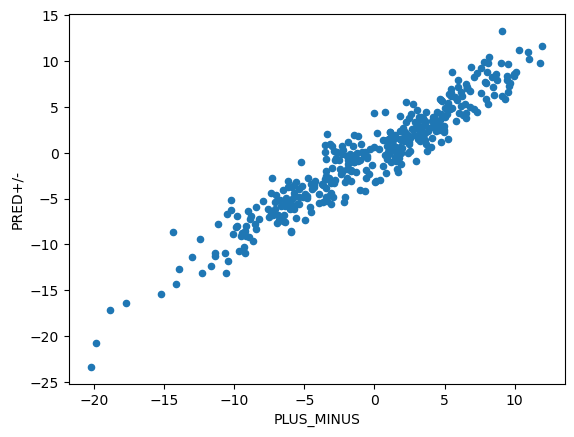

In [8]:
# Ridge - Define a regression on box plus-minus to get a prior player value.
# I was hoping to use these as a prior value for later regression on player value, but the numbers aren't sufficient.
# There's too much bias for role players on good teams.
players_box = get_player_box_and_hustle(season,season_type,per_mode,min_minutes)
model = Ridge()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 10, 100]}
grid_search = grid_search_regress(players_box, model, parameters, y_value, drop_columns, cv=2)
print('Best parameters: ' + str(grid_search.best_params_) + '. Best Score: ' + str(grid_search.best_score_))
# Ridge results in too many good stats being negative (like PFD and Charges Drawn)
ridge = regress_after_grid_search(players_box, Ridge(alpha=grid_search.best_params_['alpha']), y_value, drop_columns)
ridge_results = pd.DataFrame({'coef':ridge.coef_, 'stat':players_box.drop(drop_columns+[y_value], axis=1, errors='ignore').columns}).sort_values(by = 'coef', ascending = False)
display(ridge_results)
print('')
# Ridge priors
players_box['PRED+/-'] = get_player_box_from_regress(players_box, ridge, y_value, drop_columns)
players_box.plot('PLUS_MINUS', 'PRED+/-', kind='scatter')
players_box.sort_values(by='PRED+/-', ascending=False).head(50)
# The table below is the Ridge Regression estimate of how much each box-score, hustle, drive, and distance stat contributes to net points scored by a player.
# The highest-ranked players are often role players on great teams. This doesn't get used later - I was considering using it as a prior for the advanced
#   play-by-play regression later, but found better results from a different method.

In [9]:
# Note - I also tried KMeans regression, Bayesian Ridge regression, Kernel Ridge regression, and Random Forest regression.
# However, none of these did better at estimating prior player value than the basic Ridge regression above.

In [10]:
# # This code pulls play-by-play data and stores it in a CSV so it can be loaded in later without having to consistently re-scrape NBA API's.
# now_time = str(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())).replace(' ','-').replace(':','-')
# # Run game data
# problem_games = []
# completed_games = []
# i = 0
# for game in games['GAME_ID'].values:
#     if i == 0:
#         results = get_game_data(game_id=game,games=games)
#         results.to_csv('play_by_play_run'+now_time+'.csv')
#         completed_games.append(game)
#     else:
#         try:
#             results = get_game_data(game_id=game,games=games)
#             completed_games.append(game)
#             results.to_csv('play_by_play_run'+now_time+'.csv', mode='a', header=False)
#         except Exception as e:
#             print('Problem with run ' + str(i+1) + ', game id ' + str(game))
#             print(e)
#             problem_games.append(game)
#         if (i+1)%10 == 0:
#             print('Run ' + str(i+1) + ' completed. ' + str(len(games['GAME_ID'])-i+1) + ' to go.')
#     i+=1
#     # Wait time to not get banned from API
#     time.sleep(random.randint(5,10))
# print('Done with the errors in the problem_games list.')

In [11]:
# # The code abvoe stores the list of games that didn't pull play-by-play data properly. This is code to rerun that list of non-pulled games until it's empty.
# # Rerun problem games that didn't get data properly
# i = 0
# length_problem_games = len(problem_games)
# for game in problem_games[:]:
#     i+=1
#     try:
#         results = get_game_data(game_id=game,games=games)
#         completed_games.append(game)
#         results.to_csv('play_by_play_run'+now_time+'.csv', mode='a', header=False)
#         problem_games.remove(game)
#     except Exception as e:
#         print('Problem with run ' + str(i+1) + ', game id ' + str(game))
#         print(e)
#     if (i+1)%10 == 0:
#         print('Run ' + str(i+1) + ' completed. ' + str(length_problem_games-i+1) + ' to go.')
#     else:
#         continue
#     # Wait time to not get banned from API
#     time.sleep(random.randint(5,10))
# print('Done with the errors in the problem_games list.')

In [12]:
# # Display problem games (run above until empty)
# problem_games

In [13]:
df = pd.read_csv('play_by_play_run2023-05-22-17-33-12.csv')
# I used to drop players with fewer minutes than a minimum, but I don't do that anymore.
# df

In [14]:
# Process the play-by-play data
pd.set_option('display.max_rows', 100)
frame = df.iloc[:,:].copy()

# Flag substitutions and quarter starts so I can get the list of players on the court at one time properly.
frame['HOME_SUB']=frame['HOMEDESCRIPTION'].str.contains('SUB')
frame['AWAY_SUB']=frame['VISITORDESCRIPTION'].str.contains('SUB')
frame['QUARTER_START']=frame['NEUTRALDESCRIPTION'].str.contains('Start')
# Adding leading and lagging commas so the str replace feature works better
# Without these, player ID 1 can replace any string that has a 1 in it (like 10, 51, etc.)
frame['HOME_PLAYER_IDS']=','+frame['HOME_PLAYER_IDS']+','
frame['AWAY_PLAYER_IDS']=','+frame['AWAY_PLAYER_IDS']+','
frame['HOME_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['HOME_PLAYER_IDS'],np.nan)
frame['AWAY_PLAYER_IDS']=np.where(frame['QUARTER_START']==True,frame['AWAY_PLAYER_IDS'],np.nan)
# Set the first score to 0 - 0 for each game
frame['SCORE']=np.where(frame['Unnamed: 0']==0,'0 - 0',frame['SCORE'])
# Get time passed during the game
frame['TIME_PASSED']=np.where(frame['PERIOD']<=4,\
    (frame['PERIOD']-1)*12+12-frame['PCTIMESTRING'].str.split(':').str.get(0).astype(int)-frame['PCTIMESTRING'].str.split(':').str.get(1).astype(int)/60,\
        48+(frame['PERIOD']-5)*5+5-frame['PCTIMESTRING'].str.split(':').str.get(0).astype(int)-frame['PCTIMESTRING'].str.split(':').str.get(1).astype(int)/60)

for idx, row in frame.iterrows():
    # Do the subs by replacing the string of the player with the person subbing in for them
    if row['Unnamed: 0'] == 0 or row['QUARTER_START']==True:
        continue
    else:
        frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx-1,'AWAY_PLAYER_IDS']
        frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx-1,'HOME_PLAYER_IDS']
        if row['AWAY_SUB']==True:
            frame.at[idx,'AWAY_PLAYER_IDS']=frame.at[idx,'AWAY_PLAYER_IDS'].replace(','+str(row['PLAYER1_ID'])+',',','+str(row['PLAYER2_ID'])+',')
        if row['HOME_SUB']==True:
            frame.at[idx,'HOME_PLAYER_IDS']=frame.at[idx,'HOME_PLAYER_IDS'].replace(','+str(row['PLAYER1_ID'])+',',','+str(row['PLAYER2_ID'])+',')

# Remove subs and timeouts
frame = frame[(~frame['HOME_SUB'].fillna(False))&(~frame['AWAY_SUB'].fillna(False))]
frame = frame[(~frame['HOMEDESCRIPTION'].fillna('').str.contains('Timeout'))&(~frame['VISITORDESCRIPTION'].fillna('').str.contains('Timeout'))]
frame = frame[~frame['NEUTRALDESCRIPTION'].fillna('').str.contains('Instant Replay')]

frame.reset_index(inplace=True, drop=True)

frame['HOME_POSSESSION_END_FLAG'] = 0
frame['AWAY_POSSESSION_END_FLAG'] = 0
frame['HOMEDESCRIPTION'].fillna('',inplace=True)
frame['VISITORDESCRIPTION'].fillna('',inplace=True)

# Mark possession enders
for idx, row in frame.iterrows():
    # Turnovers
    if 'Turnover' in row['HOMEDESCRIPTION']:
        frame.at[idx,'HOME_POSSESSION_END_FLAG']=1
        continue
    if 'Turnover' in row['VISITORDESCRIPTION']:
        frame.at[idx,'AWAY_POSSESSION_END_FLAG']=1
        continue
    # Misses or makes that don't occur during non-final free throws, that aren't part of tech/flagrant, and that aren't followed by an offensive rebound
    if ('MISS' in row['HOMEDESCRIPTION'] or 'PTS' in row['HOMEDESCRIPTION'])  and not '1 of 2' in row['HOMEDESCRIPTION']\
        and not '1 of 3' in row['HOMEDESCRIPTION']  and not '2 of 3' in row['HOMEDESCRIPTION']\
        and not 'REBOUND' in frame.at[idx+1,'HOMEDESCRIPTION']\
        and not 'Technical' in row['HOMEDESCRIPTION'] and not 'Flagrant' in row['HOMEDESCRIPTION']:
        frame.at[idx,'HOME_POSSESSION_END_FLAG']=1
        continue
    if ('MISS' in row['VISITORDESCRIPTION'] or 'PTS' in row['VISITORDESCRIPTION']) and not '1 of 2' in row['VISITORDESCRIPTION']\
        and not '1 of 3' in row['VISITORDESCRIPTION'] and not '2 of 3' in row['VISITORDESCRIPTION']\
        and not 'REBOUND' in frame.at[idx+1,'VISITORDESCRIPTION']\
        and not 'Technical' in row['VISITORDESCRIPTION'] and not 'Flagrant' in row['VISITORDESCRIPTION']:
        frame.at[idx,'AWAY_POSSESSION_END_FLAG']=1
        continue

# Finalize scores-at-time and score-differences-at-time
frame['SCORE'].ffill(inplace=True)
frame['AWAY_SCORE']=frame['SCORE'].str.split(' - ').str.get(0)
frame['AWAY_SCORE']=np.where(frame['AWAY_SCORE']=='',np.nan,frame['AWAY_SCORE'])
frame['AWAY_SCORE'].ffill(inplace=True)
frame['AWAY_SCORE'].fillna(0,inplace=True)
frame['HOME_SCORE']=frame['SCORE'].str.split(' - ').str.get(1)
frame['HOME_SCORE'].ffill(inplace=True)
frame['HOME_SCORE'].fillna(0,inplace=True)
frame['HOME_SCORE_DIFFERENCE']=np.where(frame['Unnamed: 0']==0,0,frame['HOME_SCORE'].astype(int)-frame['HOME_SCORE'].astype(int).shift(1))
frame['AWAY_SCORE_DIFFERENCE']=np.where(frame['Unnamed: 0']==0,0,frame['AWAY_SCORE'].astype(int)-frame['AWAY_SCORE'].astype(int).shift(1))
frame['HOME_SCORE_DIFFERENCE'].fillna(0,inplace=True)
frame['AWAY_SCORE_DIFFERENCE'].fillna(0,inplace=True)
frame['HOME_VS_AWAY_DIFFERENCE']=frame['HOME_SCORE_DIFFERENCE']-frame['AWAY_SCORE_DIFFERENCE']
frame

,Unnamed: 0,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,HOME,AWAY,HOME_PLAYER_IDS,AWAY_PLAYER_IDS,HOME_SUB,AWAY_SUB,QUARTER_START,TIME_PASSED,HOME_POSSESSION_END_FLAG,AWAY_POSSESSION_END_FLAG,AWAY_SCORE,HOME_SCORE,HOME_SCORE_DIFFERENCE,AWAY_SCORE_DIFFERENCE,HOME_VS_AWAY_DIFFERENCE
0,0,22101224,2,12,0,1,8:41 PM,12:00,,Start of 1st Period (8:41 PM EST),,0 - 0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,0,MIN,CHI,",1630162,1629020,1629675,1627736,201976,",",1629750,1630172,202684,1628972,1630245,",NaN,NaN,True,0.000000,0,0,0,0,0.0,0.0,0.0
1,1,22101224,4,10,0,1,8:41 PM,12:00,Jump Ball Reid vs. Thompson: Tip to Beasley,NaN,,0 - 0,NaN,4.0,1629675,Naz Reid,1.610613e+09,Minnesota,Timberwolves,MIN,5,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,4,1627736,Malik Beasley,1.610613e+09,Minnesota,Timberwolves,MIN,1,MIN,CHI,",1630162,1629020,1629675,1627736,201976,",",1629750,1630172,202684,1628972,1630245,",False,NaN,NaN,0.000000,0,0,0,0,0.0,0.0,0.0
2,2,22101224,7,2,79,1,8:41 PM,11:46,MISS Edwards 25' 3PT Pullup Jump Shot,NaN,,0 - 0,NaN,4.0,1630162,Anthony Edwards,1.610613e+09,Minnesota,Timberwolves,MIN,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,",1630162,1629020,1629675,1627736,201976,",",1629750,1630172,202684,1628972,1630245,",False,NaN,NaN,0.233333,1,0,0,0,0.0,0.0,0.0
3,3,22101224,8,4,0,1,8:41 PM,11:42,,NaN,Dosunmu REBOUND (Off:0 Def:1),0 - 0,NaN,5.0,1630245,Ayo Dosunmu,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,",1630162,1629020,1629675,1627736,201976,",",1629750,1630172,202684,1628972,1630245,",NaN,False,NaN,0.300000,0,0,0,0,0.0,0.0,0.0
4,4,22101224,9,1,57,1,8:42 PM,11:28,,NaN,Thompson 5' Driving Hook Shot (2 PTS),2 - 0,-2,5.0,202684,Tristan Thompson,1.610613e+09,Chicago,Bulls,CHI,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,1,MIN,CHI,",1630162,1629020,1629675,1627736,201976,",",1629750,1630172,202684,1628972,1630245,",NaN,False,NaN,0.533333,0,1,2,0,0.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497480,419,22100654,593,1,1,4,2:43 PM,0:48,,NaN,Valanciunas 26' 3PT Jump Shot (22 PTS) (Graham...,90 - 104,14,5.0,202685,Jonas Valanciunas,1.610613e+09,New Orleans,Pelicans,NOP,5,1628984,Devonte' Graham,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,BOS,NOP,",1628369,203471,1627759,202683,1630174,",",202685,1628404,1628984,1627742,1630529,",NaN,False,NaN,47.200000,0,1,90,104,0.0,3.0,-3.0
497481,420,22100654,595,7,5,4,2:43 PM,0:29,,NaN,Valanciunas Violation:Kicked Ball (T.Maddox),90 - 104,NaN,5.0,202685,Jonas Valanciunas,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,0,BOS,NOP,",1628369,203471,1627759,202683,1630174,",",202685,1628404,1628984,1627742,1630529,",NaN,False,NaN,47.516667,0,0,90,104,0.0,0.0,0.0
497482,421,22100654,597,5,1,4,2:44 PM,0:21,Tatum Bad Pass Turnover (P2.T14),NaN,Graham STEAL (2 STL),90 - 104,NaN,4.0,1628369,Jayson Tatum,1.610613e+09,Boston,Celtics,BOS,5,1628984,Devonte' Graham,1.610613e+09,New Orleans,Pelicans,NOP,0,0,NaN,NaN,NaN,NaN,NaN,1,BOS,NOP,",1628369,203471,1627759,202683,1630174,",",202685,1628404,1628984,1627742,1630529,",False,False,NaN,47.650000,1,0,90,104,0.0,0.0,0.0
497483,422,22100654,599,1,41,4,2:44 PM,0:16,,NaN,Hart 1' Running Layup (13 PTS) (Graham 5 AST),92 - 104,12,5.0,1628404,Josh Hart,1.610613e+09,Ne

In [15]:
# Aggregate the net scores and possessions per home-away lineup combination

# # Uncomment the below to remove garbage time minutes (defined as score > 15 apart)
# frame = frame[(frame['AWAY_SCORE'].astype(int)-frame['HOME_SCORE'].astype(int)).abs()<15]

frame_agg = frame.groupby(['HOME_PLAYER_IDS','AWAY_PLAYER_IDS'], as_index=False)\
    .agg({'HOME_VS_AWAY_DIFFERENCE':'sum','HOME_POSSESSION_END_FLAG':'sum','AWAY_POSSESSION_END_FLAG':'sum'})
frame_agg['POSSESSIONS']=np.maximum(frame_agg['HOME_POSSESSION_END_FLAG']+frame_agg['AWAY_POSSESSION_END_FLAG'],1)
frame_agg['HOME_PLAYER_IDS']=frame_agg['HOME_PLAYER_IDS'].str[1:-1].str.split(',')
frame_agg['AWAY_PLAYER_IDS']=frame_agg['AWAY_PLAYER_IDS'].str[1:-1].str.split(',')
frame_agg

,HOME_PLAYER_IDS,AWAY_PLAYER_IDS,HOME_VS_AWAY_DIFFERENCE,HOME_POSSESSION_END_FLAG,AWAY_POSSESSION_END_FLAG,POSSESSIONS
0,"[101108, 1626163, 1626164, 203109, 1628969]","[1626174, 1630224, 1630256, 1629645, 201569]",-2.0,2,3,5
1,"[101108, 1626164, 1629028, 1628969, 203109]","[203110, 201939, 1626172, 1629308, 1630228]",2.0,1,0,1
2,"[101108, 1626164, 1629028, 1628969, 203109]","[203110, 201939, 202357, 1629308, 1630228]",0.0,2,2,4
3,"[101108, 1626164, 1629028, 1628969, 203109]","[203110, 203490, 1626172, 1629308, 1627780]",3.0,3,3,6
4,"[101108, 1626164, 1629028, 1628969, 203109]","[203110, 203490, 1626172, 201939, 1627780]",-7.0,5,6,11
...,...,...,...,...,...,...
35454,"[2772, 2544, 2730, 202340, 201566]","[1626220, 202711, 203497, 1628378, 201144]",-6.0,19,21,40
35455,"[2772, 2544, 2730, 202340, 201566]","[1626220, 202711, 203497, 1628378, 204060]",-3.0,5,5,10
35456,"[2772, 2730, 1628370, 1630559, 1629659]","[1628378, 202711, 204060, 203903, 200752]",1.0,1,1,2
35457,"[2772, 2730, 201566, 202340, 1629659]","[1628378, 202711, 1626220, 203903, 200752]",1.0,6,6,12


In [16]:
# Set up a dataframe to run a regression on the lineups without any prior
test_df = frame_agg.iloc[:,:].copy()
# Split the lineups to columns from the home team players, setting their values to +1
mlb = MultiLabelBinarizer()
home_mlb = pd.DataFrame(mlb.fit_transform(test_df['HOME_PLAYER_IDS']), columns=mlb.classes_, index=test_df.index)
test_df = test_df.merge(home_mlb, how='inner', left_index=True, right_index=True)
# Away player values are -1
for idx,row in test_df.iterrows():
    for player in row['AWAY_PLAYER_IDS']:
        test_df.at[idx,player]=-1
# Players not in the lineup are 0
test_df.fillna(0, inplace=True)
groupby = list(test_df.columns[6:])
import warnings
warnings.filterwarnings('ignore')
# Re-aggregate the lineup totals
test_df = test_df.groupby(groupby, as_index=False).agg({'HOME_VS_AWAY_DIFFERENCE':'sum','POSSESSIONS':'sum'})
# Multiply the player flag by the number of possessions for the lineup
test_df[groupby] = test_df[groupby].multiply(test_df['POSSESSIONS'], axis=0)
lr_df = test_df.drop('POSSESSIONS', axis=1)
y_val = 'HOME_VS_AWAY_DIFFERENCE'
# Multiply by 100 to get values per 100 possessions
lr_df[y_val]=test_df[y_val]*100
lr_df

,101108,101139,101150,1626144,1626145,1626147,1626149,1626153,1626155,1626156,1626157,1626158,1626159,1626161,1626162,1626163,1626164,1626166,1626167,1626168,1626169,1626171,1626172,1626174,1626179,...,204038,204060,204456,2207,2544,2546,2617,2730,2738,2772,203658,1628221,1628411,1628982,1628419,1630575,203816,1630237,1628537,1630640,1630346,1630531,1629005,1630610,HOME_VS_AWAY_DIFFERENCE
0,-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-28,-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1300.0
1,-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-13,-13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0
2,-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-13,-13,0,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-200.0
4,-6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-6,-6,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33753,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0
33754,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0
33755,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
33756,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Run the regression for the lineup data without priors
regressor = Ridge()
grid_search = GridSearchCV(regressor, {'alpha':[1,10,25,50,100,250,500,1000,1500,2000,3000,4000,5000,7500,10000,15000,20000,30000,40000,50000,75000,100000,200000,500000,1000000]})
grid_search.fit(lr_df.drop(y_val, axis=1), lr_df[y_val])
print('Best parameters: ' + str(grid_search.best_params_))
fin_regressor = Ridge(alpha=grid_search.best_params_['alpha'])
fin_regressor.fit(lr_df.drop(y_val, axis=1), lr_df[y_val])
reg_results = pd.DataFrame({'coef':fin_regressor.coef_, 'player':lr_df.drop(y_val, axis=1).columns}).sort_values(by = 'coef', ascending = False)
player_minutes = get_player_minutes(season,season_type)
reg_results['player']=reg_results['player'].astype(int)
reg_results_player = reg_results.merge(player_minutes,how='inner',left_on='player',right_on='PLAYER_ID')
reg_results_player.head(50)
# The table below is the Ridge Regression estimate of plus-minus value for players strictly looking at their aggregated play-by-play stats,
#   adjusted for who they played with and against at each play.
# This regression does a surprisingly good job at projecting top players, but it's not perfect - adjusting with a prior later proves better.

Best parameters: {'alpha': 200000}


,coef,player,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,MIN
0,2.097767,201939,201939,Stephen Curry,GSW,64,2211.085000
1,1.887395,1628369,1628369,Jayson Tatum,BOS,76,2730.971667
2,1.745021,203999,203999,Nikola Jokic,DEN,74,2475.591667
3,1.694032,203935,203935,Marcus Smart,BOS,71,2295.841667
4,1.598652,1629636,1629636,Darius Garland,CLE,68,2429.953333
5,1.398039,1627780,1627780,Gary Payton II,GSW,71,1247.685000
6,1.395296,202710,202710,Jimmy Butler,MIA,57,1930.831667
7,1.333891,1627759,1627759,Jaylen Brown,BOS,66,2220.453333
8,1.330637,203954,203954,Joel Embiid,PHI,68,2296.405000
9,1.330174,203500,203500,Steven Adams,MEM,76,1998.576667


In [18]:
# Team box plus-minus to regress player stats off that instead
teams_box = get_team_box_and_hustle(season,season_type,per_mode,min_minutes)
# teams_box

Best parameters: {'alpha': 10}. Best Score: 0.7040123854850835


,coef,stat
2,0.736031,FG3MA
0,0.638689,FG2MA
7,0.608722,DREB
35,0.521096,OPP_TOV
17,0.398777,DEFLECTIONS
29,0.359959,OPP_FG3MI
6,0.358228,OREB
27,0.354493,OPP_FG2MI
23,0.349515,DEF_BOXOUTS
4,0.327155,FTMA


,TEAM_ID,TEAM_NAME,GP,W,L,MIN,FG2MA,FG2MI,FG3MA,FG3MI,FTMA,FTMI,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS,POSS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,...,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,DIST_MILES_OFF,DIST_MILES_DEF,OPP_FG2MA,OPP_FG2MI,OPP_FG3MA,OPP_FG3MI,OPP_FTMA,OPP_FTMI,OPP_OREB,OPP_DREB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,DRIVES,DRIVE_PASSES,PRED+/-
1,1610612738,Boston Celtics,82,51,31,3981.0,27.962320,23.140803,13.448190,24.281111,17.315320,3.916708,10.696579,36.130392,25.235498,13.857214,7.325235,5.924641,4.660387,18.852256,19.732276,7.399603,100.0,34.010907,21.901339,...,19.695092,3.284581,3.061477,1.735250,8.403570,1.859054,1.626202,26.871591,27.181458,12.010412,23.438275,16.410511,4.561230,10.634606,33.800198,21.975706,14.043133,7.659891,4.660387,5.924641,19.732276,18.852256,45.959346,18.145761,6.988428
9,1610612744,Golden State Warriors,82,53,29,3946.0,26.437631,21.044206,14.480975,25.304765,15.761606,4.740795,9.851004,36.079301,27.373476,15.035094,8.853589,4.580717,3.903460,21.216599,18.150474,5.590445,100.0,29.971678,23.556212,...,25.514099,2.906046,2.869105,1.428396,7.080409,1.933132,1.664628,25.994336,25.107745,12.313754,23.987194,17.559414,5.590445,9.752494,33.308706,23.088290,14.641054,7.991627,3.903460,4.580717,18.150474,21.216599,38.345031,15.897057,6.408034
23,1610612756,Phoenix Suns,82,64,18,3946.0,31.909731,26.000971,11.538462,20.201407,15.809270,4.028149,9.718515,35.343363,27.226401,12.860956,8.517350,4.355739,3.967484,19.813152,18.842514,7.461781,100.0,30.478039,19.509828,...,24.508614,2.511526,2.960446,1.358893,6.551808,1.868396,1.612923,27.456928,26.389226,11.562727,22.470274,17.180296,5.399175,10.470760,33.766076,22.749333,14.632371,7.449648,3.967484,4.355739,18.842514,19.813152,41.239990,15.809270,6.234828
28,1610612762,Utah Jazz,82,49,33,3946.0,26.640878,20.264537,14.873971,26.403793,18.342900,5.565261,11.030696,36.386324,22.909908,14.324931,7.337160,5.016222,4.392313,19.303718,20.763664,6.176691,100.0,28.824557,19.428500,...,26.965311,2.458198,2.458198,2.183679,6.039431,1.945845,1.651111,28.949339,26.965311,12.403294,22.997255,14.961318,4.766658,10.094834,32.430746,23.920639,12.253556,7.936112,4.392313,5.016222,20.763664,19.303718,53.132019,20.863489,5.475008
14,1610612763,Memphis Grizzlies,82,56,26,3956.0,31.657625,29.342978,11.392405,20.904159,16.793249,6.088005,13.972272,34.635322,25.690175,13.044002,9.644364,6.425558,5.979506,19.529837,19.590115,5.617842,100.0,32.031344,21.326100,...,22.591923,3.218807,3.339361,2.543701,6.666667,1.889594,1.659680,27.944545,25.593731,11.898734,22.194093,17.082580,5.063291,9.897529,32.622061,24.677517,14.888487,7.088608,5.979506,6.425558,19.590115,19.529837,45.533454,12.959614,5.279609
15,1610612748,Miami Heat,82,53,29,3971.0,26.693377,23.613372,13.947665,22.812070,17.728809,4.219356,10.103919,34.781520,26.167522,14.949293,7.587329,3.317892,4.131714,21.021660,21.109303,4.569926,100.0,25.190935,22.837110,...,24.640040,3.217729,3.167647,1.928133,9.452861,2.013021,1.695004,25.215976,21.710279,13.321648,25.967197,17.991737,5.108301,9.803431,32.978590,23.888819,15.374984,7.612370,4.131714,3.317892,21.109303,21.021660,40.853888,18.179542,3.965227
16,1610612749,Milwaukee Bucks,82,51,31,3951.0,27.474650,22.984066,13.918397,24.118783,17.612265,5.094157,10.140029,36.093675,23.660068,13.278609,7.520521,3.935297,4.309512,18.034766,19.459198,3.319652,100.0,28.730082,25.519073,...,16.417190,2.776437,2.836794,2.148720,7.279092,1.894013,1.679623,26.617576,22.911637,14.316755,25.857074,14.811685,4.913085,9.802028,33.860454,25.615645,12.916465,7.315307,4.309512,3.935297,19.459198,18.034766,42.105263,17.201835,3.274979
6,1610612742,Dallas Mavericks,82,52,30,3951.0,27.302757,22.487613,13.632321,25.282683,17.037225,5.056537,9.642993,35.179774,24.367933,13.022488,7.013086,4.129081,3.811460,20.480244,20.899505,3.443019,100.0,32.676915,18.536399,...,21.166307,2.515563,2.337695,1.461060,7.673739,1.9875

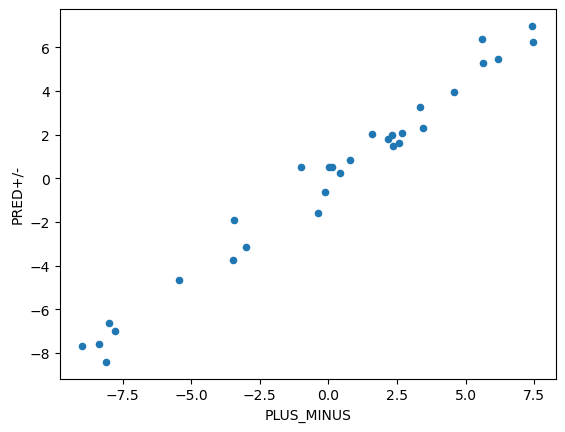

In [19]:
# Ridge - Define a regression on team box plus-minus to get a prior player value, will be used in Bayesian regression later
# This gets used as a prior value for later regression, adjusting player value.
teams_box = get_team_box_and_hustle(season,season_type,per_mode,min_minutes)
model = Ridge()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 10, 100]}
grid_search = grid_search_regress(teams_box, model, parameters, y_value, drop_columns, cv=2)
print('Best parameters: ' + str(grid_search.best_params_) + '. Best Score: ' + str(grid_search.best_score_))
ridge = regress_after_grid_search(teams_box, Ridge(alpha=grid_search.best_params_['alpha']), y_value, drop_columns)
ridge_results = pd.DataFrame({'coef':ridge.coef_, 'stat':teams_box.drop(drop_columns+[y_value], axis=1, errors='ignore').columns}).sort_values(by = 'coef', ascending = False)
display(ridge_results)
print('')
# Ridge priors
teams_box['PRED+/-'] = get_player_box_from_regress(teams_box, ridge, y_value, drop_columns)
teams_box.plot('PLUS_MINUS', 'PRED+/-', kind='scatter')
teams_box.sort_values(by='PRED+/-', ascending=False).head(50)
# Below is the list of stats that have the highest impact on team plus-minus.

,PLAYER_ID,PLAYER_NAME,GP,W,L,MIN,FG2MA,FG2MI,FG3MA,FG3MI,FTMA,FTMI,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS,POSS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,...,OFF_BOXOUTS,DEF_BOXOUTS,DIST_MILES_OFF,DIST_MILES_DEF,OPP_FG2MA,OPP_FG2MI,OPP_FG3MA,OPP_FG3MI,OPP_FTMA,OPP_FTMI,OPP_OREB,OPP_DREB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,DRIVES,DRIVE_PASSES,POSITION,PRED+/-,POS_AVG_PRED+/-,ADJ_PRED+/-
31,203507,Giannis Antetokounmpo,67,45,22,2204.225000,13.029728,8.117225,1.496943,3.605313,11.659287,4.490829,2.825216,13.577904,8.180476,4.617331,1.518027,1.918617,1.328273,4.469745,12.376133,8.370230,100.0,8.053974,4.849252,...,0.611427,1.539110,1.792298,1.492879,5.068522,4.608897,2.816783,5.135990,2.926418,0.885515,1.779464,6.489564,4.963104,2.424626,1.421042,0.788530,0.822264,4.258908,3.626397,16.487455,5.566097,F,2.598759,-5.892780,8.491538
153,1627780,Gary Payton II,71,47,24,1247.685000,6.522578,2.122733,1.659591,2.971826,1.350830,0.887688,2.778850,6.754149,2.470089,1.543805,3.705133,0.849093,0.347356,5.055963,2.006947,6.908530,100.0,3.936704,4.129680,...,0.463142,0.849093,1.904330,1.970669,5.048244,4.940178,2.377460,4.739483,3.504438,1.134697,1.945195,6.375917,4.376689,3.342339,1.528367,0.671555,1.034350,3.481281,4.322655,1.157854,0.617522,G,-1.475486,-8.800536,7.325049
322,203999,Nikola Jokic,74,46,28,2475.591667,12.986760,6.931464,1.888629,3.718847,7.379283,1.732866,4.010903,15.829439,11.370717,5.471184,2.122274,1.226636,1.285047,3.718847,9.404206,8.644860,100.0,13.454050,4.108255,...,1.265576,3.524143,1.822129,1.514548,6.012461,5.175234,2.332555,4.485981,2.698598,0.992991,1.935358,6.222741,5.140187,2.394860,1.713396,0.860592,0.704829,4.131620,3.419003,5.996885,1.985981,C,7.325473,0.051242,7.274231
326,203497,Rudy Gobert,66,42,24,2120.416667,8.262954,3.241269,0.000000,0.091303,6.916229,3.104314,5.501027,16.594385,1.643460,2.716275,1.027163,3.127140,1.095640,4.017348,8.765122,9.518375,100.0,15.453093,4.222780,...,1.917370,3.081488,1.830992,1.648349,5.414289,5.446245,2.497147,4.766035,2.597580,0.839991,1.981283,6.318192,4.597124,2.360192,1.597809,0.803470,0.935859,4.327779,3.446702,0.433691,0.045652,C,6.885195,0.051242,6.833954
57,1626172,Kevon Looney,82,53,29,1732.343333,5.819810,4.336877,0.000000,0.027980,2.098489,1.398993,5.819810,10.856184,4.616676,1.874650,1.398993,1.454952,1.007275,6.015669,2.881925,4.700616,100.0,13.878008,5.819810,...,1.762731,4.057079,1.762829,1.692089,5.405708,5.226637,2.501399,4.661444,3.385562,0.979295,1.902630,6.424175,4.829323,2.714046,1.611640,0.789032,0.962507,3.463906,4.152210,1.594852,0.475658,F,-0.417446,-5.892780,5.475333
6,1629634,Brandon Clarke,64,44,20,1246.026667,10.469848,5.253422,0.184980,0.628931,3.144654,1.664817,4.994451,7.658158,3.181650,1.257862,1.442841,2.515723,0.961894,4.513504,4.069552,6.511284,100.0,9.877913,4.661487,...,1.183870,2.922679,1.901916,1.694776,5.297817,5.194229,2.315945,4.528302,3.788383,1.235664,1.975583,6.392897,4.728080,2.870884,1.331853,1.139475,1.583426,3.958565,4.269330,4.069552,0.961894,F,-0.471885,-5.892780,5.420895
288,203954,Joel Embiid,68,45,23,2296.405000,12.349138,10.991379,2.004310,3.405172,14.094828,3.211207,3.146552,14.008621,6.120690,4.612069,1.659483,2.133621,1.767241,3.900862,12.521552,7.931034,100.0,11.099138,2.844828,...,0.818966,3.017241,1.722287,1.539065,5.900862,5.547414,2.198276,4.245690,3.146552,0.974138,2.120690,7.060345,4.741379,2.568966,1.297414,0.827586,1.056034,4.318966,3.577586,7.693966,1.379310,C-F,4.267426,-0.576992,4.844418
222,201939,Stephen Curry,64,45,19,2211.085000,5.377501,4.818240,6.130351,10.002151,5.915251,0.494730,0.731340,6.474511,8.690041,4.431060,1.828350,0.494730,0.838890,2.796300,4.861260,10.948591,100.0,2.495160,3.656700,...,0.064530,0.494730,1.981147,1.520816,5.226931,5.011831,2.280060,4.770918,3.342654,1.023876,2.039148,6.435793,4.405248,3.015702,1.634760,0.752850,1.002366,3.506130,4.155732,13.207141,5.786191,G,-3.984159,-8.800536,4.816377
4,1626171,Bobby Portis,72,46,26,2028.340000,6.587799,5.77

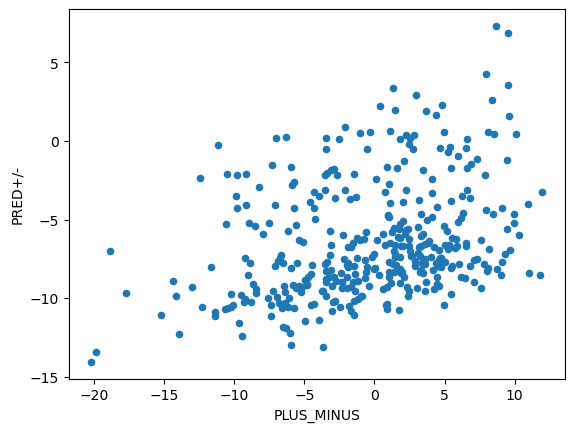

In [20]:
# This was my favorite prior I found, using team stats to train a model and then predicting player values from it.
# I then adjust the player value based on their positional average
players_box = get_player_box_and_hustle(season,season_type,per_mode,min_minutes)
players_box = players_box.merge(players[['PLAYER_ID','POSITION']], how='inner', on='PLAYER_ID')
# Ridge priors for player
players_box['PRED+/-'] = get_player_box_from_regress(players_box, ridge, y_value, drop_columns)
players_box.plot('PLUS_MINUS', 'PRED+/-', kind='scatter')
avg_pos_val = players_box.groupby('POSITION').agg({'PRED+/-':'mean'}).reset_index()
avg_pos_val.columns=['POSITION','POS_AVG_PRED+/-']
players_box = players_box.merge(avg_pos_val, how='inner', on='POSITION')
players_box['ADJ_PRED+/-'] = players_box['PRED+/-']-players_box['POS_AVG_PRED+/-']
players_box.sort_values(by='ADJ_PRED+/-', ascending=False).head(50)

In [21]:
# I originally had a prior version here where I used how many minutes a player played in and how strong a team's +/-
# was to predict a player's +/-. However, again this overstated the values of secondary players on good teams.

In [22]:
# Using the team-trained player-predicted prior from above
player_prior_dict = {}
for idx,row in players_box.iterrows():
    # Adjusting down by 1/5th because the prior values are ~5x larger than the naive regression of lineups from above
    player_prior_dict[row['PLAYER_ID']] = row['ADJ_PRED+/-']/5

In [23]:
# Doing regression with my form of box-plus-minus prior
# Copy the regression df
lr_df_p = lr_df.iloc[:,:].copy()
# Loop through each row to get the prior value for the players on the court (0 if missing)
# and add that nultiplied by the number of possessions for those players to get the prior y val
# (basically use the predicted box-plus-minus per 100 possessions and multiply that by the 
# players on the court for the possesions they had)
for idx,row in lr_df_p.drop(y_val, axis=1).iterrows():
    prior_ys = []
    players = row[row!=0].index
    possessions = row[row!=0].values
    for player,possession in zip(players,possessions):
        try:
            prior_ys.append(player_prior_dict[int(player)]*possession)
        except:
            prior_ys.append(0)
    lr_df_p.at[idx,'PRIOR_Y_VAL']=sum(prior_ys)
lr_df_p['NEW_Y'] = lr_df_p[y_val]-lr_df_p['PRIOR_Y_VAL']

In [24]:
# Now use a ridge regression to predict the adjusted net points value
regressor = Ridge()
grid_search = GridSearchCV(regressor, {'alpha':[1,10,25,50,100,250,500,1000,1500,2000,3000,4000,5000,7500,10000,15000,20000,30000,40000,50000,75000,100000,200000,500000,1000000]})
grid_search.fit(lr_df_p.drop([y_val,'PRIOR_Y_VAL','NEW_Y'], axis=1), lr_df_p['NEW_Y'])
print('Best parameters: ' + str(grid_search.best_params_))

Best parameters: {'alpha': 200000}


In [25]:
# Apply the regression, show player's prior, observed, and posterior value
fin_regressor = Ridge(alpha=grid_search.best_params_['alpha'])
fin_regressor.fit(lr_df_p.drop([y_val,'PRIOR_Y_VAL','NEW_Y'], axis=1), lr_df_p['NEW_Y'])
reg_results = pd.DataFrame({'obs_coef':fin_regressor.coef_, 'player':lr_df.drop(y_val, axis=1).columns})
reg_results['player']=reg_results['player'].astype(int)
reg_results_player = reg_results.merge(player_minutes,how='inner',left_on='player',right_on='PLAYER_ID')
for idx,row in reg_results_player.iterrows():
    try:
        reg_results_player.at[idx,'prior_coef'] = player_prior_dict[int(row['PLAYER_ID'])]
    except:
        reg_results_player.at[idx,'prior_coef'] = 0
reg_results_player['obs_coef_adj'] = reg_results_player['obs_coef']
reg_results_player['post_coef'] = reg_results_player['obs_coef_adj'] + reg_results_player['prior_coef']
reg_results_player.sort_values(by='post_coef', ascending=False).head(50)

,obs_coef,player,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,MIN,prior_coef,obs_coef_adj,post_coef
577,1.448227,203999,203999,Nikola Jokic,DEN,74,2475.591667,1.454846,1.448227,2.903073
465,1.516762,201939,201939,Stephen Curry,GSW,64,2211.085000,0.963275,1.516762,2.480037
53,0.916208,1627780,1627780,Gary Payton II,GSW,71,1247.685000,1.465010,0.916208,2.381218
79,1.558239,1628369,1628369,Jayson Tatum,BOS,76,2730.971667,0.805189,1.558239,2.363429
542,0.745634,203497,203497,Rudy Gobert,UTA,66,2120.416667,1.366791,0.745634,2.112424
573,1.112059,203954,203954,Joel Embiid,PHI,68,2296.405000,0.968884,1.112059,2.080943
548,0.286367,203507,203507,Giannis Antetokounmpo,MIL,67,2204.225000,1.698308,0.286367,1.984674
110,1.023177,1628449,1628449,Chris Boucher,TOR,80,1690.111667,0.841021,1.023177,1.864198
567,1.493187,203935,203935,Marcus Smart,BOS,71,2295.841667,0.326640,1.493187,1.819827
214,1.914877,1629636,1629636,Darius Garland,CLE,68,2429.953333,-0.113473,1.914877,1.801404


In [26]:
# Other options for priors could be something like ranking a player's +/- compared to their team and/or teammates, then using the average by rank.
# But for now, I think this is pretty okay.

# # TODO: Possibilities to consider:
# Run for multiple years
# Aggregate players value for their minutes played to rank MVPs